Data shape: (3346, 34)
Unique treatment groups after cleaning:
['Rt Alone' 'Chemort' 'Rt + Egfri' 'Postop RT alone']
Unique tumor stages after cleaning:
['IVB' 'I' 'IVA' 'III' 'II' 'IV' nan 'IIIC' 'IB' 'X' 'IIA' 'IIIA' 'IVC'
 'IIB']


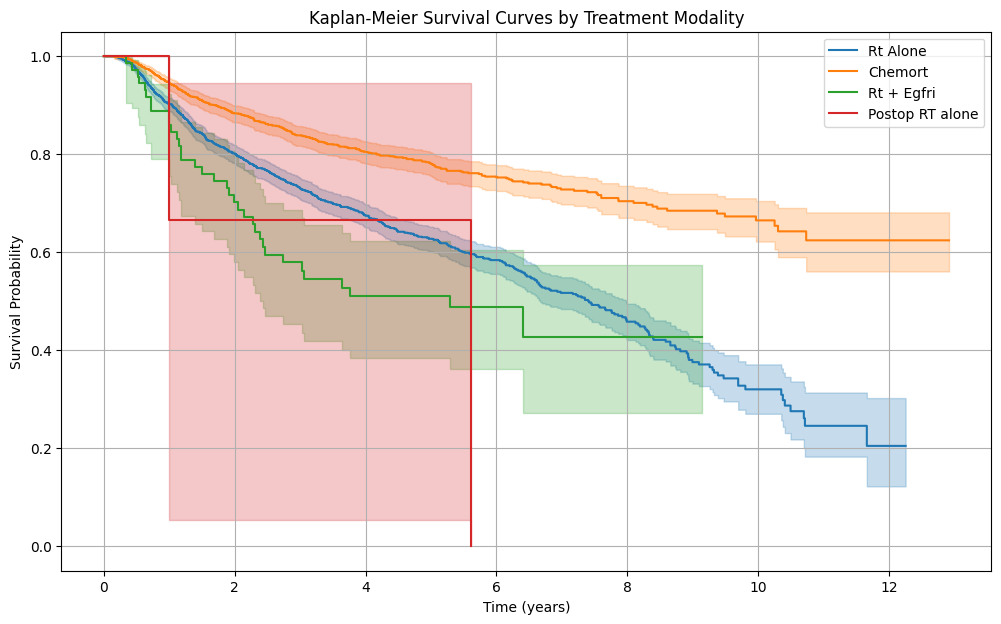

Skipping empty tumor stage: nan


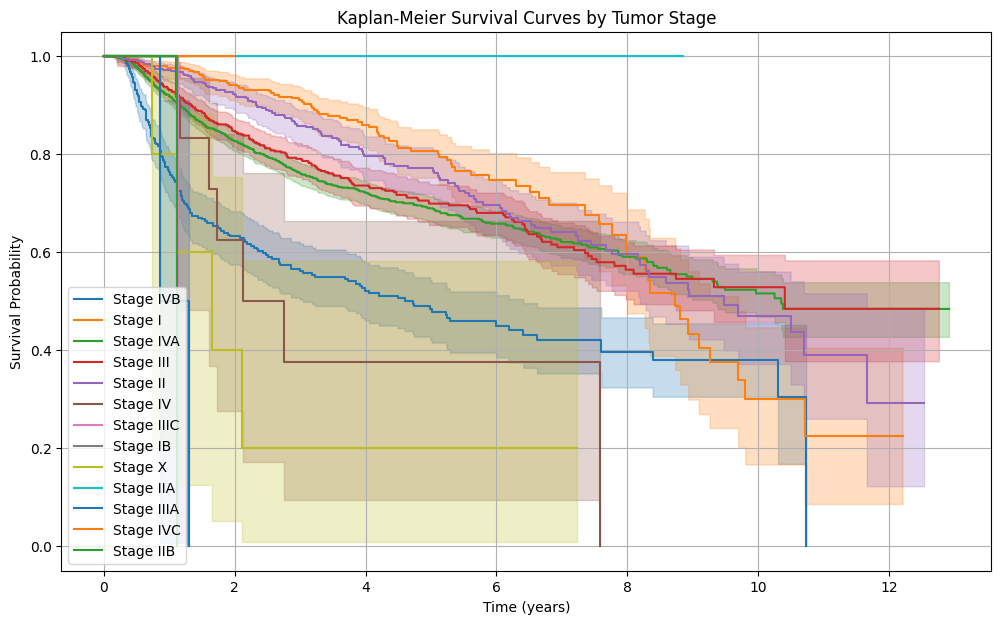

Training Random Survival Forest...
RSF training completed in 0.98 seconds
Calculating permutation importance...
Permutation importance completed in 16.35 seconds


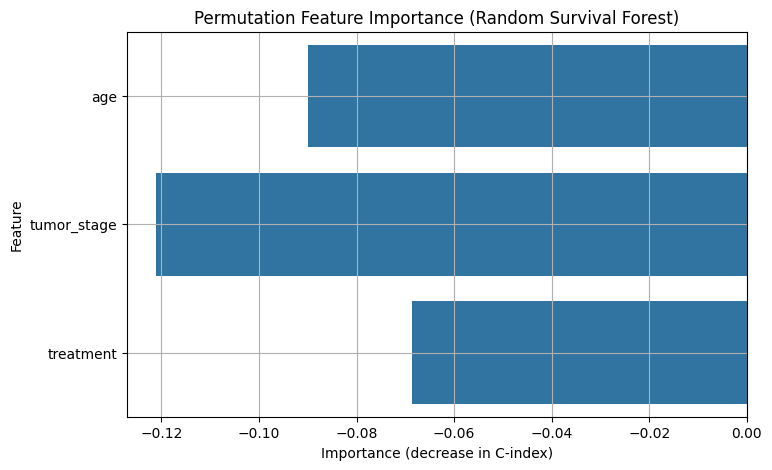

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import KaplanMeierFitter
from sklearn.preprocessing import LabelEncoder
from sksurv.ensemble import RandomSurvivalForest
from sksurv.util import Surv
from sksurv.metrics import concordance_index_censored
import time

# Load data
df = pd.read_excel(r"C:\Users\Pankaj\BINF5507_SurvivalAnalysis_A4\Data\RADCURE_Clinical_v04_20241219.xlsx")
print(f"Data shape: {df.shape}")

# Clean and prepare column names
df.columns = df.columns.str.strip()
df = df.rename(columns={
    'Length FU': 'time',
    'Status': 'event',
    'Age': 'age',
    'Tx Modality': 'treatment',
    'Stage': 'tumor_stage'
})

# Select relevant columns and drop NA
df_clean = df[['time', 'event', 'age', 'treatment', 'tumor_stage']].dropna()

# Map event column to binary
df_clean['event'] = df_clean['event'].str.strip().str.lower().map({
    'dead': 1, 'deceased': 1, 'alive': 0, 'censored': 0
})
df_clean = df_clean.dropna(subset=['event'])
df_clean['event'] = df_clean['event'].astype(int)

# Clean and standardize treatment
df_clean['treatment'] = df_clean['treatment'].str.strip().str.title()
df_clean['treatment'] = df_clean['treatment'].replace({
    'Chemo Rt Other': 'Chemo RT other',
    'Postop Rt Alone': 'Postop RT alone',
    # Add other mappings if needed
})

print("Unique treatment groups after cleaning:")
print(df_clean['treatment'].unique())

# Clean and standardize tumor_stage
df_clean['tumor_stage'] = df_clean['tumor_stage'].str.strip().str.upper()

print("Unique tumor stages after cleaning:")
print(df_clean['tumor_stage'].unique())

kmf = KaplanMeierFitter()

# -----------------------------------------------
# 1. KM Curves by Treatment (with safety checks)
# -----------------------------------------------
plt.figure(figsize=(12, 7))
for group in df_clean['treatment'].unique():
    mask = df_clean['treatment'] == group
    subset = df_clean.loc[mask, ['time', 'event']]

    if subset.empty:
        print(f"Skipping empty treatment group: {group}")
        continue
    if not np.issubdtype(subset['time'].dtype, np.number) or not np.issubdtype(subset['event'].dtype, np.number):
        print(f"Skipping treatment group {group} due to non-numeric data")
        continue
    if subset['time'].isnull().any() or subset['event'].isnull().any():
        print(f"Skipping treatment group {group} due to NaNs in time/event")
        continue

    kmf.fit(subset['time'], subset['event'], label=group)
    kmf.plot_survival_function(ci_show=True)

plt.title("Kaplan-Meier Survival Curves by Treatment Modality")
plt.xlabel("Time (years)")
plt.ylabel("Survival Probability")
plt.grid(True)
plt.legend()
plt.show()

# -----------------------------------------------
# 2. KM Curves by Tumor Stage (with safety checks)
# -----------------------------------------------
plt.figure(figsize=(12, 7))
for stage in df_clean['tumor_stage'].unique():
    mask = df_clean['tumor_stage'] == stage
    subset = df_clean.loc[mask, ['time', 'event']]

    if subset.empty:
        print(f"Skipping empty tumor stage: {stage}")
        continue
    if not np.issubdtype(subset['time'].dtype, np.number) or not np.issubdtype(subset['event'].dtype, np.number):
        print(f"Skipping tumor stage {stage} due to non-numeric data")
        continue
    if subset['time'].isnull().any() or subset['event'].isnull().any():
        print(f"Skipping tumor stage {stage} due to NaNs in time/event")
        continue

    kmf.fit(subset['time'], subset['event'], label=f"Stage {stage}")
    kmf.plot_survival_function(ci_show=True)

plt.title("Kaplan-Meier Survival Curves by Tumor Stage")
plt.xlabel("Time (years)")
plt.ylabel("Survival Probability")
plt.grid(True)
plt.legend()
plt.show()

# -----------------------------------------------
# 3. Random Survival Forest
# -----------------------------------------------
X_rsf = df_clean[['age', 'tumor_stage', 'treatment']].copy()
X_rsf['tumor_stage'] = LabelEncoder().fit_transform(X_rsf['tumor_stage'])
X_rsf['treatment'] = LabelEncoder().fit_transform(X_rsf['treatment'])
y_rsf = Surv.from_dataframe('event', 'time', df_clean)

rsf = RandomSurvivalForest(n_estimators=30, min_samples_split=10, min_samples_leaf=15, random_state=42)

print("Training Random Survival Forest...")
start = time.time()
rsf.fit(X_rsf, y_rsf)
print(f"RSF training completed in {time.time() - start:.2f} seconds")

def permutation_importance_survival(estimator, X, y, n_repeats=3, random_state=None):
    rng = np.random.default_rng(random_state)
    baseline_pred = estimator.predict(X)
    baseline_score = concordance_index_censored(y['event'], y['time'], -baseline_pred)[0]

    importances = np.zeros(X.shape[1])

    for i, col in enumerate(X.columns):
        scores = []
        X_permuted = X.copy()

        for _ in range(n_repeats):
            X_permuted[col] = rng.permutation(X_permuted[col].values)
            pred = estimator.predict(X_permuted)
            score = concordance_index_censored(y['event'], y['time'], -pred)[0]
            scores.append(baseline_score - score)
            X_permuted[col] = X[col]

        importances[i] = np.mean(scores)

    return importances

print("Calculating permutation importance...")
start = time.time()
importances = permutation_importance_survival(rsf, X_rsf, y_rsf, n_repeats=3, random_state=42)
print(f"Permutation importance completed in {time.time() - start:.2f} seconds")

# Ensure importances are numeric and no NaNs
importances = np.array(importances, dtype=float)
if np.isnan(importances).any():
    importances = np.nan_to_num(importances)  # replace NaNs with 0

features = list(X_rsf.columns)

plt.figure(figsize=(8, 5))
sns.barplot(x=importances, y=features)
plt.title("Permutation Feature Importance (Random Survival Forest)")
plt.xlabel("Importance (decrease in C-index)")
plt.ylabel("Feature")
plt.grid(True)
plt.show()
